In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
from sklearn.model_selection import train_test_split
from pandasql import sqldf
import os
import h5py
import time
from datetime import timedelta
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()


# Load data
'''
W: operative conditions (Scenario descriptors): 작동조건
X_s: measured signals: 측정된 신호
X_v: virtual sensors: 가상 센서
T(theta): engine health parameters: 엔진 상태 매개변수
Y: RUL [in cycles]
A: auxiliary data: 보조 데이터
'''

'\nW: operative conditions (Scenario descriptors): 작동조건\nX_s: measured signals: 측정된 신호\nX_v: virtual sensors: 가상 센서\nT(theta): engine health parameters: 엔진 상태 매개변수\nY: RUL [in cycles]\nA: auxiliary data: 보조 데이터\n'

### Set-up - Define file location

In [3]:
# Get h5 filenames 함수
def get_h5_filenames(folder_path):
    h5_filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".h5"):
            h5_filenames.append(filename)
    return h5_filenames

# file derectory의 전체 파일 읽어서 filename 지정
current_dir = os.getcwd()
h5_filenames = get_h5_filenames(current_dir + "/raw_data")
h5_filenames.sort()
filename = "raw_data/"+h5_filenames[0]

with h5py.File(filename, 'r') as hdf:
        # Development(training) set
        W_dev = np.array(hdf.get('W_dev'))             # W 
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0)

print("Filename: ", filename)
print("Operation time (min): " , (time.process_time()-t)/60)
print ("number of training samples(timestamps): ", Y_dev.shape[0])
print ("number of testing  samples(timestamps): ", Y_test.shape[0])
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("Y shape: " + str(Y.shape))
print ("A shape: " + str(A.shape))

Filename:  raw_data/N-CMAPSS_DS01-005.h5
Operation time (min):  0.040246849999999994
number of training samples(timestamps):  4906636
number of testing  samples(timestamps):  2735232

W shape: (7641868, 4)
X_s shape: (7641868, 14)
X_v shape: (7641868, 14)
T shape: (7641868, 10)
Y shape: (7641868, 1)
A shape: (7641868, 4)


In [4]:
# df _ W, Xs, Y, A
df_W = DataFrame(data=W, columns=W_var)
df_Xs = DataFrame(data=X_s, columns=X_s_var)
df_Xv = DataFrame(data=X_v, columns=X_v_var)
df_T = DataFrame(data=T, columns=T_var)
df_Y = DataFrame(data=Y, columns=['RUL'])
df_A = DataFrame(data=A, columns=A_var)
# 각 feature가 'signalVariable, labelVariable, derivedVariable' 로 구분 필요_추후에 생각해보자

df_all = pd.concat([df_W, df_Xs, df_Xv, df_T, df_Y, df_A], axis=1)
df_all.columns

Index(['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2',
       'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30',
       'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan',
       'SmLPC', 'SmHPC', 'phi', 'fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod',
       'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod',
       'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod', 'RUL', 'unit', 'cycle',
       'Fc', 'hs'],
      dtype='object')

In [6]:
# unit_list
unitList = [df_all['unit'].unique()]
print("unitList")
print(unitList)

unitList
[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])]


In [5]:
# Single Unit Data
numUnit = 5
singleUnitData = df_all[df_all['unit'] == np.float64(numUnit)]
print("singleUnitData_shape")
print(singleUnitData.shape)

# unit의 max cycle
unitMaxCycle = singleUnitData['cycle'].max()
print()
print("unitMaxCycle")
print(unitMaxCycle)

singleUnitData_shape
(1280147, 47)

unitMaxCycle
89.0


In [6]:
# Pick a cycle
cycleNumber = 1
singleCycleData = singleUnitData[singleUnitData['cycle'] == np.float64(cycleNumber)]
singleCycleData.head(1)

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,RUL,unit,cycle,Fc,hs
2789639,3001.0,0.343728,76.552193,519.971264,621.853983,1491.106944,1891.719921,1289.874733,19.527462,14.255861,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0


In [7]:
# Time 변수
Time = [timedelta(seconds=i) for i in range(len(singleCycleData))]
print("Total Cycle time(sec): "+str(len(Time)))
Time_array = np.array([float(t.total_seconds()) for t in Time]).astype(int)
print("Total Cycle time(sec): "+str(len(Time_array)))

Total Cycle time(sec): 15058
Total Cycle time(sec): 15058


### Smooth Data 함수 (moving average)

In [8]:
# moving average ratio 함수
def moving_average_ratio(data, window_ratio):
    window_size = int(window_ratio * len(data))
    half_window = window_size // 2
    kernel = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data.values, kernel, mode='same')
    smoothed_series = pd.Series(smoothed_data, index=data.index)
    # 처음과 끝 부분 처리
    smoothed_series.iloc[:half_window] = data.iloc[:half_window].mean()
    smoothed_series.iloc[-half_window:] = data.iloc[-half_window:].mean()
    
    return smoothed_series

def moving_average_size(data, window_size):
    half_window = window_size // 2
    kernel = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data.values, kernel, mode='same')
    smoothed_series = pd.Series(smoothed_data, index=data.index)
    # 처음과 끝 부분 처리
    smoothed_series.iloc[:half_window] = data.iloc[:half_window].mean()
    smoothed_series.iloc[-half_window:] = data.iloc[-half_window:].mean()
    
    return smoothed_series

### Identify Flight Phases

/var/folders/7d/d1khjvv95fs1dx3zplr2sfzh0000gn/T/ipykernel_6552/3781675090.py:18: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  altitude = singleCycleData['alt'][:-1] # altChange 계산결과와 맞추기 위해 행 하나 줄임


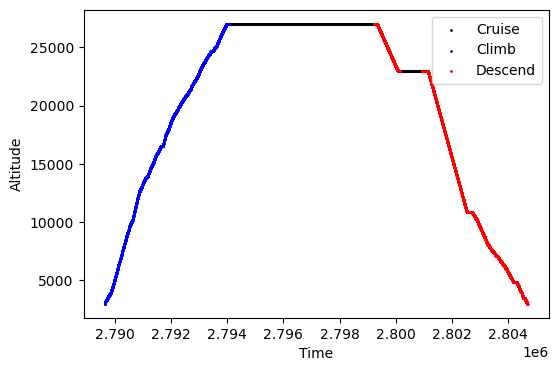

In [9]:
# altitude와 altitudeShifted 계산
altitude = singleCycleData['alt'].iloc[:-1].reset_index(drop=True) # index reset
altitudeShifted = singleCycleData['alt'].iloc[1:].reset_index(drop=True) # index reset

# alt 변화 계산
altChange = altitudeShifted - altitude

# AltChange 데이터 smoothing
smoothedAltChange = moving_average_ratio(altChange, 0.05)
smoothedAltChange = np.array(smoothedAltChange)

# Cruise/Climb/Descend 영역 인덱스 생성
cruiseIdx = np.logical_and(np.greater_equal(smoothedAltChange, -2), np.less_equal(smoothedAltChange, 2))
climbIdx = np.greater(smoothedAltChange, 2)
descendIdx = np.less(smoothedAltChange, -2)

# altitude 데이터 가져오기
altitude = singleCycleData['alt'][:-1] # altChange 계산결과와 맞추기 위해 행 하나 줄임

# 그래프 생성
plt.figure(figsize=(6, 4))

# Cruise/Climb/Descend 영역 표시
cruise_altitude = altitude[cruiseIdx]
plt.scatter(cruise_altitude.index, cruise_altitude, color='black', label='Cruise', s=1)
climb_altitude = altitude[climbIdx]
plt.scatter(climb_altitude.index, climb_altitude, color='blue', label='Climb', s=1)
descend_altitude = altitude[descendIdx]
plt.scatter(descend_altitude.index, descend_altitude, color='red', label='Descend', s=1)

plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.show()

### Moving AVG _ 그래프로 확인

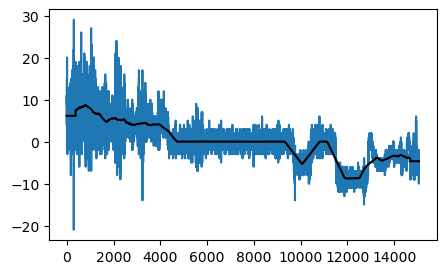

In [10]:
# altChange, smoothedAltChange 비교
singleCycleDataAlt = singleCycleData['alt']

plt.figure(figsize=(5,3))
plt.plot(Time_array[:-1], altChange, alpha=1.0)
plt.plot(Time_array[:-1], smoothedAltChange, alpha=1.0, color='black')

### Reduce Data by Extracting Change Points

In [11]:
singleCycleData[:][:-1][cruiseIdx].shape
singleCycleDataCruise = singleCycleData[:][:-1][cruiseIdx]
singleCycleData[:-2000]

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,RUL,unit,cycle,Fc,hs
2789639,3001.0,0.343728,76.552193,519.971264,621.853983,1491.106944,1891.719921,1289.874733,19.527462,14.255861,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
2789640,3010.0,0.344295,76.112740,519.977768,621.442896,1489.497325,1888.709915,1288.437775,19.500338,14.255044,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
2789641,3016.0,0.343728,75.761177,519.916373,621.003519,1487.987402,1886.111148,1287.290699,19.468269,14.247989,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
2789642,3025.0,0.343539,75.409622,519.867938,620.609662,1486.526262,1883.373907,1285.967534,19.438843,14.241695,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
2789643,3036.0,0.342405,75.145950,519.753544,620.213625,1485.347641,1881.498120,1285.184313,19.405647,14.228722,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802692,10875.0,0.509418,44.999680,504.794301,572.036916,1305.539762,1559.250870,1106.284863,14.226789,11.637198,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
2802693,10874.0,0.509103,43.417660,504.768339,570.827108,1298.410325,1542.012065,1097.196595,14.166667,11.635249,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
2802694,10873.0,0.508599,42.626648,504.722318,569.462194,1295.428705,1542.740764,1100.920926,14.107675,11.631691,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0
2802695,10870.0,0.508221,41.132519,504.695278,568.336835,1288.497417,1524.624644,1090.813280,14.054570,11.629969,...,0.0,-0.000705,0.0,0.0,0.0,88,5.0,1.0,3.0,1.0


변화점 갯수: 200
변화점 위치: [2796864, 2794972, 2794239, 2795109, 2795956, 2797717, 2796119, 2794990, 2795179, 2796537, 2794236, 2797206, 2795173, 2794501, 2795197, 2795188, 2794989, 2794277, 2797715, 2795392, 2795191, 2796177, 2797810, 2796957, 2796534, 2796248, 2794925, 2795011, 2794603, 2797210, 2795395, 2795672, 2795174, 2794974, 2796332, 2795020, 2794604, 2795671, 2794991, 2797056, 2795114, 2794992, 2796121, 2797809, 2795111, 2795955, 2795195, 2795557, 2795559, 2797703, 2796663, 2794757, 2797856, 2795190, 2794647, 2797443, 2797855, 2795112, 2797107, 2794237, 2797978, 2795199, 2795954, 2797701, 2797960, 2796247, 2797808, 2795434, 2796110, 2796866, 2795389, 2796959, 2797635, 2795556, 2796980, 2796262, 2794276, 2796467, 2795204, 2795074, 2797477, 2795957, 2796456, 2795782, 2796298, 2796115, 2795019, 2797497, 2797807, 2795069, 2796079, 2797441, 2795128, 2797598, 2797377, 2795162, 2794970, 2796272, 2796664, 2795014, 2795346, 2796181, 2795390, 2797055, 2794832, 2797486, 2795693, 2797669, 2794602

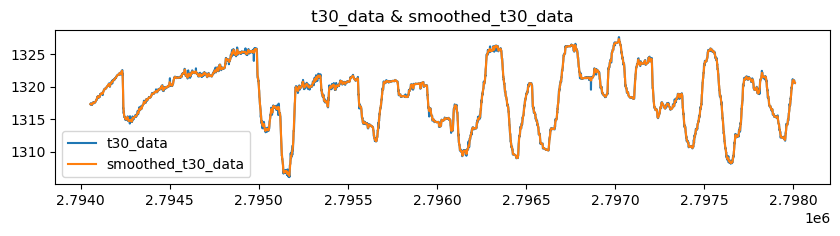

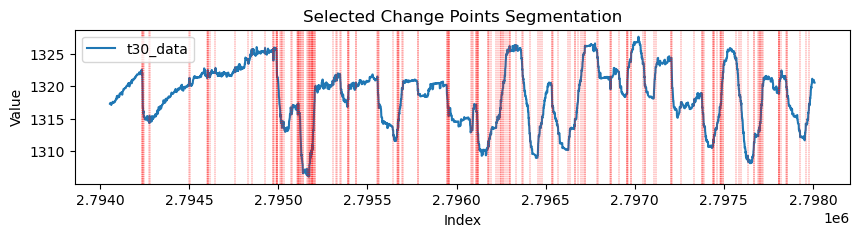

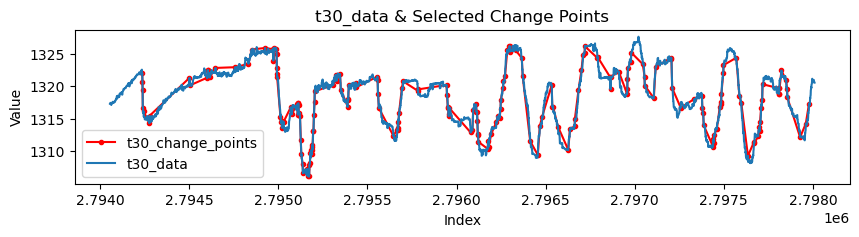

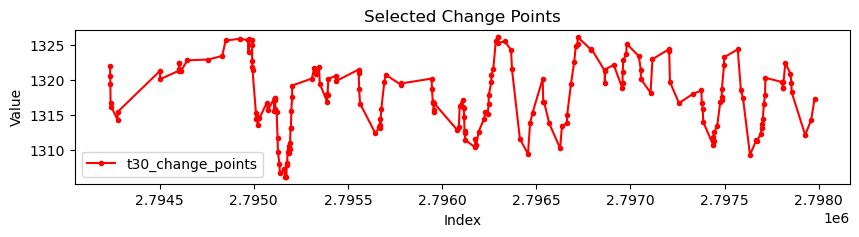

In [12]:
# singleCycleData의 Cruise구간 추출
singleCycleDataCruise = singleCycleData[:][:-1][cruiseIdx] # cruiseIdx와 row 맞추기 위해 -1
singleCycleDataCruise = singleCycleDataCruise[:-2000] # 두번째 Cruise 구간 생략

# singleCycleData에서 'T30' 열 추출
t30_data = singleCycleDataCruise['T30']

# smoothing T30 data(단위: time sliding size)
timeSlidingSize = 5 # 단위:seconds
smoothedT30Data = moving_average_size(t30_data, timeSlidingSize)

# 변화량이 있는 point 추출_ 원래 값과 moving_average 값의 차이를 구함
threshold = smoothedT30Data.std() * 0.001 # n은 적절한 임계값 배수
changePointIdxList = []
for i in range(timeSlidingSize - 1, len(smoothedT30Data)):
    if abs(t30_data.iloc[i] - smoothedT30Data.iloc[i]) > threshold:
        changePointIdxList.append(t30_data.index[i])

# 변화량이 큰 순서대로 정렬하여 최대 n개의 변화점 선택
changePointIdxList.sort(key=lambda x: abs(t30_data.loc[x] - smoothedT30Data.loc[x]), reverse=True)
max_change_points_num = 200
max_change_points = min(len(changePointIdxList), max_change_points_num)
selected_change_points = changePointIdxList[:max_change_points]
print("변화점 갯수:", len(selected_change_points))
print("변화점 위치:", selected_change_points)

# selected_change_points 정렬
sorted_change_points = sorted(selected_change_points)
print("변화점 위치_sort:", sorted_change_points)
# selected_change_points에 해당하는 데이터 추출
change_point_data = t30_data.loc[sorted_change_points]
change_point_data.to_csv("change_point.csv")

# t30_data & smoothed_t30_data 그래프
plt.figure(figsize=(10,2))
plt.plot(t30_data, label='t30_data')
plt.plot(smoothedT30Data, label='smoothed_t30_data')
plt.title('t30_data & smoothed_t30_data')
plt.legend()

# change points segmentation 그래프
plt.figure(figsize=(10,2))
plt.plot(t30_data.index, t30_data.values, label='t30_data')
plt.title('Selected Change Points Segmentation')

for change_point in selected_change_points: # 변화점 위치 표시
    plt.axvline(x=change_point, color='r', linestyle='--', linewidth=0.3)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# t30_data & selected_change_points 그래프
plt.figure(figsize=(10,2))
plt.plot(change_point_data.index, change_point_data.values, marker='o', color='r', markersize=3, label='t30_change_points')
plt.plot(t30_data.index, t30_data.values, label='t30_data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('t30_data & Selected Change Points')
plt.legend()

# selected_change_points의 값들로만 구성된 그래프
plt.figure(figsize=(10,2))
plt.plot(change_point_data.index, change_point_data.values, marker='o', color='r', markersize=3, label='t30_change_points')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Selected Change Points')
plt.legend()

plt.show()
